In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from math import sqrt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 

import graphviz
from graphviz import Graph

import env
import wrangle
import os

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

In [2]:
# change setting to show all columns
pd.set_option('display.max_columns', None)

In [3]:
# use function to pull in zillow data
df = wrangle.get_zillow_data()
df.head()

,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,261.0,10952984,2417912,NaN,NaN,NaN,4.0,4.0,NaN,8.0,4.0,NaN,NaN,2961.0,2961.0,NaN,NaN,NaN,NaN,6037.0,NaN,4.0,NaN,NaN,NaN,2.0,34193355.0,-118307273.0,8127.0,1.0,NaN,NaN,NaN,1.0,0101,BUR1*,6.037310e+07,396054.0,3101.0,NaN,96433.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1963.0,NaN,NaN,331167.0,546265.0,2016.0,215098.0,6071.89,NaN,NaN,6.037310e+13,892,0.034615,2017-01-05,Single Family Residential
1,261.0,12653289,2871196,NaN,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1572.0,1572.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,7.0,33726742.0,-118301532.0,5000.0,NaN,NaN,NaN,NaN,NaN,0104,LAR1,6.037297e+07,12447.0,3101.0,54300.0,96221.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1924.0,NaN,NaN,105762.0,227863.0,2016.0,122101.0,2770.35,NaN,NaN,6.037297e+13,891,-0.080755,2017-01-05,Single Family Residential
2,261.0,12612840,1514581,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,NaN,NaN,1540.0,1540.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,7.0,33797217.0,-118314255.0,5555.0,NaN,NaN,NaN,NaN,NaN,0100,LOR1*,6.037670e+07,53027.0,3101.0,NaN,96217.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1953.0,NaN,NaN,29440.0,63380.0,2016.0,33940.0,1104.70,NaN,NaN,6.037670e+13,889,0.079772,2017-01-05,Single Family Residential
3,261.0,12611007,216904,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,NaN,NaN,1470.0,1470.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33801082.0,-118312214.0,7287.0,NaN,NaN,NaN,NaN,NaN,0100,LOR1*,6.037670e+07,53027.0,3101.0,NaN,96217.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1958.0,NaN,NaN,71733.0,182691.0,2016.0,110958.0,2506.91,NaN,NaN,6.037670e+13,888,0.100001,2017-01-05,Single Family Residential
4,261.0,12023386,304078,NaN,NaN,NaN,2.0,2.0,NaN,8.0,2.0,NaN,NaN,1533.0,1533.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34109199.0,-118383568.0,3124.0,NaN,NaN,NaN,NaN,NaN,0100,LAR1,6.037194e+07,12447.0,3101.0,113749.0,96027.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1963.0,NaN,NaN,52583.0,87557.0,2016.0,34974.0,1229.29,NaN,NaN,6.037194e+13,886,-0.006511,2017-01-05,Single Family Residential


In [4]:
# check info (nulls, dtypes, columns, size, etc)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         52441 non-null  float64
 1   parcelid                      52441 non-null  int64  
 2   id                            52441 non-null  int64  
 3   airconditioningtypeid         13638 non-null  float64
 4   architecturalstyletypeid      70 non-null     float64
 5   basementsqft                  47 non-null     float64
 6   bathroomcnt                   52441 non-null  float64
 7   bedroomcnt                    52441 non-null  float64
 8   buildingclasstypeid           0 non-null      float64
 9   buildingqualitytypeid         33740 non-null  float64
 10  calculatedbathnbr             52304 non-null  float64
 11  decktypeid                    389 non-null    float64
 12  finishedfloor1squarefeet      4381 non-null   float64
 13  c

In [5]:
# save original columns to list
original_df_cols = df.columns.tolist()

In [6]:
# create a function to return list of columns with greater than a set percentage of nulls
def get_cols_with_large_null_percentage(df, percentage):
    '''
    This function takes in a dataframe and a percentage and returns a list of columns that have 
    a greater percentage of nulls than provided as an argument
    '''
    
    # Set null threshold. Any columns that have this ratio or higher of nulls will be removed
    null_perc_thresh = percentage

    # Create empty list to keep track of which columns to drop
    cols_with_many_nulls = []

    # Loop through df and append columns with null percentage higher than specified to cols_to_drop list
    for col in df.columns:
        num_nulls = df[col].isnull().sum()
        if num_nulls == 0:
            continue
        null_perc = num_nulls / len(df)
        if null_perc > null_perc_thresh:
            cols_with_many_nulls.append(col)
        
    return cols_with_many_nulls

In [7]:
# create variable to hold and review cols to drop
cols_to_drop = (get_cols_with_large_null_percentage(df, 0.35))
cols_to_drop

['airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertyzoningdesc',
 'regionidneighborhood',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'numberofstories',
 'fireplaceflag',
 'taxdelinquencyflag',
 'taxdelinquencyyear']

In [8]:
# drop columns with too many nulls
df = df.drop(columns=cols_to_drop)

In [9]:
# check columns
df.columns

Index(['propertylandusetypeid', 'parcelid', 'id', 'bathroomcnt', 'bedroomcnt',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'id.1', 'logerror',
       'transactiondate', 'propertylandusedesc'],
      dtype='object')

In [10]:
# check that all properties had a transaction during 2017
df.transactiondate.value_counts()

2017-06-30    810
2017-04-28    617
2017-05-31    566
2017-07-28    546
2017-08-31    528
             ... 
2017-03-25      1
2017-03-12      1
2017-06-03      1
2017-08-12      1
2017-06-11      1
Name: transactiondate, Length: 257, dtype: int64

In [11]:
# check that all properties are single family residential
df.propertylandusedesc.value_counts()

Single Family Residential    52441
Name: propertylandusedesc, dtype: int64

In [12]:
# specify more columns to drop based on usefulness
more_cols_to_drop = ['propertylandusetypeid','id','calculatedbathnbr',
                     'finishedsquarefeet12','fullbathcnt','latitude',
                     'longitude','propertycountylandusecode',
                     'rawcensustractandblock','regionidzip',
                     'structuretaxvaluedollarcnt','assessmentyear',
                     'landtaxvaluedollarcnt','taxamount',
                     'censustractandblock','id.1','logerror',
                     'transactiondate','propertylandusedesc',
                     'regionidcity','regionidcounty','parcelid']

In [13]:
# drop additional columns
df = df.drop(columns=more_cols_to_drop)
df.head(3)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt
0,4.0,4.0,2961.0,6037.0,8127.0,0.0,1963.0,546265.0
1,2.0,3.0,1572.0,6037.0,5000.0,0.0,1924.0,227863.0
2,2.0,3.0,1540.0,6037.0,5555.0,0.0,1953.0,63380.0


In [14]:
# check info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   52441 non-null  float64
 1   bedroomcnt                    52441 non-null  float64
 2   calculatedfinishedsquarefeet  52359 non-null  float64
 3   fips                          52441 non-null  float64
 4   lotsizesquarefeet             52072 non-null  float64
 5   roomcnt                       52441 non-null  float64
 6   yearbuilt                     52325 non-null  float64
 7   taxvaluedollarcnt             52440 non-null  float64
dtypes: float64(8)
memory usage: 3.6 MB


In [15]:
# create an age column
df['age'] = 2021-df.yearbuilt
df.head(3)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt,age
0,4.0,4.0,2961.0,6037.0,8127.0,0.0,1963.0,546265.0,58.0
1,2.0,3.0,1572.0,6037.0,5000.0,0.0,1924.0,227863.0,97.0
2,2.0,3.0,1540.0,6037.0,5555.0,0.0,1953.0,63380.0,68.0


In [16]:
# Rename some columns for simplicity
df = df.rename(columns={'bedroomcnt':'bedrooms',
                        'bathroomcnt':'bathrooms',
                        'calculatedfinishedsquarefeet':'area',
                        'lotsizesquarefeet':'lot_area',
                        'roomcnt':'total_num_of_rooms',
                        'taxvaluedollarcnt':'taxvalue'})

In [17]:
# check bedroom value counts
df.bedrooms.value_counts()

3.0     23359
4.0     15240
2.0      8340
5.0      3973
6.0       635
1.0       612
0.0       137
7.0       106
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: bedrooms, dtype: int64

In [18]:
# check for nulls
df.isnull().sum()

bathrooms               0
bedrooms                0
area                   82
fips                    0
lot_area              369
total_num_of_rooms      0
yearbuilt             116
taxvalue                1
age                   116
dtype: int64

In [19]:
# drop rows with null values
df = df.dropna()
df.shape

(51959, 9)

In [20]:
# Create list of datatypes I want to change
int_col_list = ['bedrooms','area','taxvalue','age']
obj_col_list = ['yearbuilt']
    
# Change data types where it makes sense
for col in df:
    if col in int_col_list:
        df[col] = df[col].astype(int)
    if col in obj_col_list:
        df[col] = df[col].astype(int).astype(object)

In [21]:
# check descriptive statistics
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,bathrooms,bedrooms,area,fips,lot_area,total_num_of_rooms,taxvalue,age
count,51959,51959,51959,51959,51959,51959,51959,51959
mean,2.29716,3.30495,1918.25,6049.15,11251.6,1.90427,525552,57.7522
std,1.01117,0.934239,994.308,21.0341,86640.6,3.15276,716442,22.9762
min,0,0,128,6037,236,0,1000,5
25%,2,3,1268,6037,5581.5,0,193482,42
50%,2,3,1657,6037,6838,0,372791,61
75%,3,4,2301,6059,8777,5,616742,71
max,13,11,21929,6111,6.97101e+06,15,2.53812e+07,143


In [22]:
# check total number of rooms, there's quite a few that have zero so this may not be a useful feature
df.total_num_of_rooms.value_counts()

0.0     37438
6.0      3977
7.0      3604
8.0      2810
5.0      1876
9.0      1176
4.0       503
10.0      339
11.0      105
3.0        69
12.0       34
2.0        11
13.0       10
14.0        5
15.0        1
1.0         1
Name: total_num_of_rooms, dtype: int64

In [23]:
# use a function to remove outliers
df = wrangle.remove_outliers(df,1.5,['bedrooms','bathrooms','area','lot_area','taxvalue','age'])
df.shape

(40549, 9)

In [24]:
# check descriptive statistics
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,bathrooms,bedrooms,area,fips,lot_area,total_num_of_rooms,taxvalue,age
count,40549,40549,40549,40549,40549,40549,40549,40549
mean,2.07181,3.19695,1657.76,6049.15,6625.22,1.97231,363589,58.8723
std,0.710089,0.781355,581.799,20.9118,2046.07,3.12645,235058,20.9813
min,1,2,152,6037,1292,0,3254,7
25%,2,3,1227,6037,5400,0,171827,45
50%,2,3,1540,6037,6500,0,331810,62
75%,2.5,4,1991,6059,7678,5,508446,71
max,4,5,3557,6111,12510,12,1.08226e+06,109


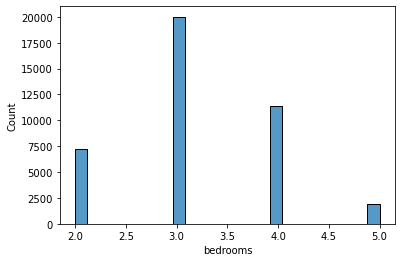

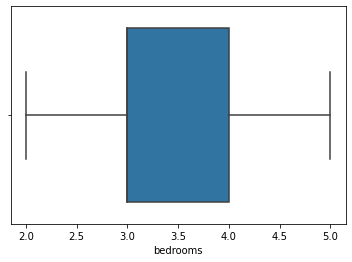

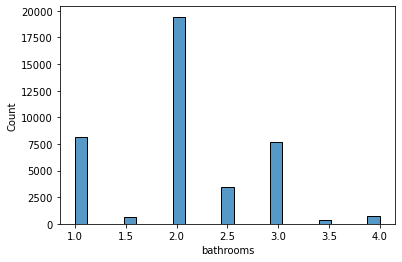

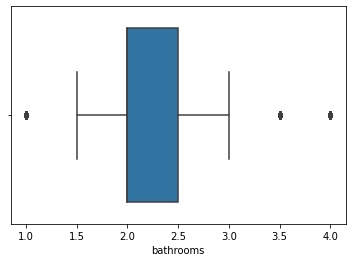

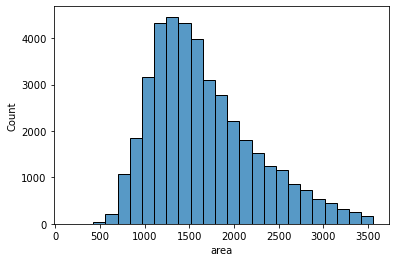

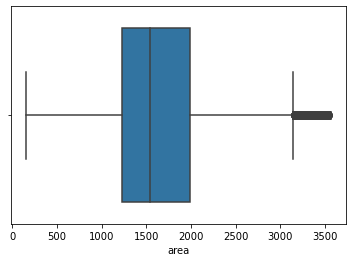

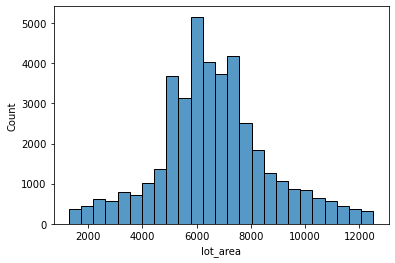

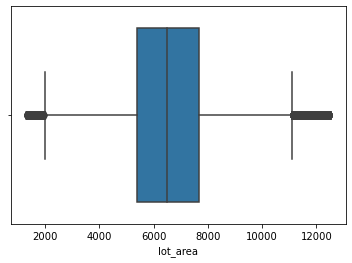

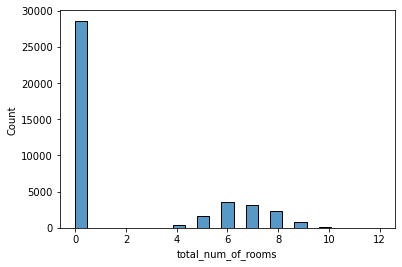

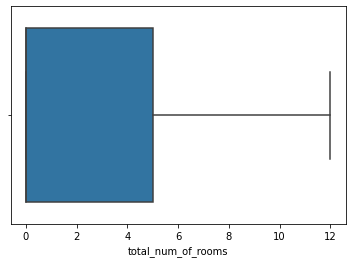

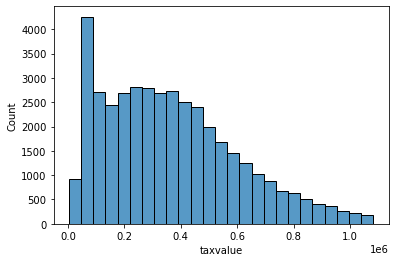

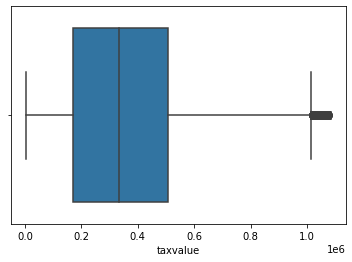

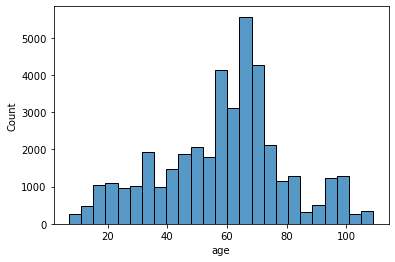

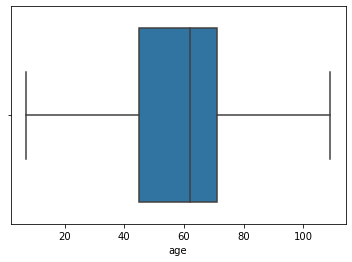

In [25]:
# check distribution of numerical columns
num_cols = ['bedrooms', 'bathrooms', 'area','lot_area','total_num_of_rooms',
            'taxvalue', 'age']
for col in num_cols: 
    sns.histplot(df[col], log_scale=[False,False], bins=25)
    plt.show()
    sns.boxplot(df[col])
    plt.show()

In [26]:
# check outliers for taxvalue greater than 1,500,000 or less than 50,000
(df.taxvalue > 1_500_000).sum(), (df.taxvalue < 50_000).sum()

(0, 1220)

In [27]:
# check number of observations with area greater than 4000 or less than 500 ft
(df.area > 3500).sum(), (df.area < 500).sum()

(56, 8)

In [28]:
# drop observations with area greater than 3500 or less than 500
df = df[(df.area < 3500) & (df.area > 500)]

In [29]:
# drop observations with area greater than 3500 or less than 500
df = df[(df.taxvalue < 1_500_000) & (df.taxvalue > 50_000)]

In [30]:
# check current shape
df.shape

(39265, 9)

In [31]:
# check fips value counts
df.fips.value_counts()

6037.0    24990
6059.0    10989
6111.0     3286
Name: fips, dtype: int64

In [32]:
# replace fips number with city and state they represent for readability
df.fips = df.fips.replace({6037:'Los Angeles, CA',6059:'Orange, CA',6111:'Ventura, CA'})
df.head()

,bathrooms,bedrooms,area,fips,lot_area,total_num_of_rooms,yearbuilt,taxvalue,age
0,4.0,4,2961,"Los Angeles, CA",8127.0,0.0,1963,546265,58
1,2.0,3,1572,"Los Angeles, CA",5000.0,0.0,1924,227863,97
2,2.0,3,1540,"Los Angeles, CA",5555.0,0.0,1953,63380,68
3,2.0,3,1470,"Los Angeles, CA",7287.0,0.0,1958,182691,63
4,2.0,2,1533,"Los Angeles, CA",3124.0,0.0,1963,87557,58


In [33]:
# encode fips column
dummy_df = pd.get_dummies(df['fips'])
dummy_df.head()

,"Los Angeles, CA","Orange, CA","Ventura, CA"
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [34]:
# concatenate dummy variables onto df and drop fips column
df = pd.concat([df, dummy_df], axis=1).drop(columns=['fips','total_num_of_rooms'])
df.head(3)

,bathrooms,bedrooms,area,lot_area,yearbuilt,taxvalue,age,"Los Angeles, CA","Orange, CA","Ventura, CA"
0,4.0,4,2961,8127.0,1963,546265,58,1,0,0
1,2.0,3,1572,5000.0,1924,227863,97,1,0,0
2,2.0,3,1540,5555.0,1953,63380,68,1,0,0


In [35]:
# check shape
df.shape

(39265, 10)

In [36]:
# check function
df = wrangle.clean_zillow_data(wrangle.get_zillow_data())
df.shape

(39265, 10)

In [38]:
# check function
train, validate, test = wrangle.split_data(df)
train.shape, validate.shape, test.shape

((21988, 10), (9424, 10), (7853, 10))

In [39]:
# check function
train, validate, test = wrangle.wrangle_zillow()
train.shape, validate.shape, test.shape

((21988, 10), (9424, 10), (7853, 10))

In [40]:
train.head()

,bathrooms,bedrooms,area,lot_area,yearbuilt,taxvalue,age,"Los Angeles, CA","Orange, CA","Ventura, CA"
29532,2.5,4,3023,6000.0,1970,119834,51,0,1,0
3604,3.0,4,1745,5977.0,1956,559188,65,0,1,0
37044,2.0,4,1950,6804.0,1968,599723,53,0,1,0
41278,3.0,4,2136,10944.0,1967,98955,54,1,0,0
6683,2.0,3,1291,6790.0,1986,122666,35,1,0,0
